# HW2：二值逻辑回归 binary logistics regression

discriminative

题目：预测一个人的工资是否能超过 $ 50000

Kaggle: https://www.kaggle.com/c/ml2020spring-hw2

Simple baseline: 0.88675

Strong baseline:0.89102

第一次的分数：0.5880

第二次的分数：0.88567 (<font color='red'>**未达标**</font>)

**关键词：** Discriminative model; Binary classfication; Logistic regression; Mini-Batch Gradient Descent;

**大致思路：**读取数据 → 正则化输入数据 → 划分数据集 → 设置参数 → 训练（使用交叉熵 + 小批量梯度下降 + 缓速学习速率）→ 正则化测试数据 → 输出结果 → 提交kaggle → 写Generative Model代码

## 代码如下：


In [1]:
# logistic model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
EPS = 1e-8

np.random.seed(0)    # used in mini-batch gradient descent to shuffle array
# read files
x = pd.read_csv('./data/X_train.csv', index_col=0).astype(np.float).to_numpy()
y = pd.read_csv('./data/Y_train.csv', index_col=0).astype(np.int).to_numpy().flatten()     # 1-D dimension use VECTOR.
x_test = pd.read_csv('./data/X_test.csv',index_col=0).astype(np.float).to_numpy()

* 在小批量梯度下降法(MBGD)中，需要不断的打乱顺序进行训练，需要使用numpy中的random
* 对于分类的标签数据类型没必要是float类型，只需要int类型即可。一维标签数据使用  *flatten()*  函数表示向量(n,).
* 定义EPS($\epsilon$)防止除零异常

In [2]:
# === some useful function ===

sigmoid = lambda z: np.clip(1 / (1 + np.exp(-z)),EPS,1-EPS) #clip函数用于处理异常结果，使结果处在 [EPS, 1-EPS] 区间内

def normalize(x: np.ndarray):  # 正则化函数
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    return (x - x_mean) / (x_std + EPS)  # 使用EPS即可省略判断为0的情况


def shuffle(x, y):    # 打乱数组
    """shuffle the dataset, often using MBGD

    Args:
        x ([np.ndarray]): [input dataset]
        y ([np.ndarray]): [label dataset]

    Returns:
        (x,y): shuffled input dataset and label dataset
    """
    randomize = np.arange(len(x))
    np.random.shuffle(randomize)
    return x[randomize], y[randomize]


def divideSet(x, y, ratio=0.25):    # 用于分割数据集
    p = int(len(x)*(1-ratio))
    return x[:p, :], x[p:, :], y[:p], y[p:]

一些操作会经常使用在重复计算的操作中，因此可以将常用的操作写成函数，方便后续使用。

In [3]:
# regularization / normalization
x = normalize(x)

# divide set
x_train, x_valid, y_train, y_valid = divideSet(x, y, 0.1)
train_size = len(x_train)
valid_size = len(x_valid)
print(f'training dataset size: {train_size}')
print(f'validation / devlopment dataset size: {valid_size}')

training dataset size: 48830
validation / devlopment dataset size: 5426


先对数据集进行正则化，然后进行数据分割

In [4]:
def cross_entrophy(y_pred, y_label):
    return -np.dot(y_label,np.log(y_pred+EPS)) - np.dot(1-y_label,np.log(1-y_pred+EPS))

def gradient(x, y_label, w):
    """
    Returns:
        (w_grad,b_grad): weight and bias gradient descent
    """
    return np.dot(x.T, sigmoid(np.dot(x, w)) - y_label)

def predict(x, w, is_bool = True):
    # use to binary classification
    if is_bool:
        return np.round(sigmoid(np.dot(x, w)))
    else:
        return sigmoid(np.dot(x, w))

def accurate(y, y_label):
    # calculate the accuracy
    return 1 - np.mean(np.abs(y - y_label))

* 定义交叉熵函数，用于分类的损失函数
* gradient梯度函数，注意这里的正负号，以及在函数中是否省略。$-\sum(y^\text{^}-y(x,w))x_i$
* 这里的predict函数适用于计算函数值，方便后续使用。对于这里的`is_bool`参数<font color='red'>极其重要</font>：对于`is_bool=True`不需要计算loss的时候直接得出最终预测的结果bool值；对于`is_bool=False`时候需要计算loss损失值，这十分关键，因为对于每一次的预测值，不是100%的预测，而是一个float类型的值，相对于预测的可信度。对于一个值0.56与0.96来讲，对应的最终二值分类的结果两者可能都为1，都是可能性不同，如果直接使用最后预测的结果`1`来看，反而会缺失精度，造成预测结果不准确。
* acccurate函数用于计算最终预测的准确度。

In [5]:
#  === start train Mini-Batch Gradient decent ===

# MBGD variable config
max_iter = 20   # 最多迭代次数
batch_size = 16    # 对于深度学习中，如果使用GPU进行训练，batch size最好为2的次方数字。
eta = 0.2    # 学习速率

# variables for plotting
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []

# weights and coefficients
dim = x_train.shape[1] + 1
w = np.zeros((dim,))

step = 1    # use to decay learning rate

* 相比于普通的RMSE迭代，其迭代的次数较少。在深度学习中MBGD使用的次数也更加频繁。
* 使用的学习速率要进行缓速（decay），防止步长过长导致进行梯度下降的次数增多。因此设置step参数。

In [6]:
for epoch in range(max_iter):
    # shuffle dataset
    x_train, y_train = shuffle(x_train, y_train)
    for idx in range(int(np.floor(train_size / batch_size))):
        x_batch = x_train[idx*batch_size:(idx+1)*batch_size]
        y_batch = y_train[idx*batch_size:(idx+1)*batch_size]
        x_batch = np.concatenate((np.ones((len(x_batch),1)), x_batch), 1)

        w_grad = gradient(x_batch,y_batch,w)
        w = w - eta / np.sqrt(step) * w_grad
        step += 1

    # Compute loss and accuracy
    y_train_pred = predict(np.concatenate((np.ones((train_size,1)), x_train), 1),w,False)
    Y_train_pred = np.round(y_train_pred)
    train_accuracy.append(accurate(Y_train_pred, y_train))
    train_loss.append(cross_entrophy(y_train_pred, y_train) / train_size)

    y_valid_pred = predict(np.concatenate((np.ones((valid_size,1)), x_valid), 1),w,False)
    Y_valid_pred = np.round(y_valid_pred)
    valid_accuracy.append(accurate(Y_valid_pred,y_valid))
    valid_loss.append(cross_entrophy(y_valid_pred,y_valid) / valid_size)

print(f"train loss {round(train_loss[-1],2)}, training accuracy {round(train_accuracy[-1],2)}")
print(f"validation loss {round(valid_loss[-1],2)}, validation accuracy {round(valid_accuracy[-1],2)}")

train loss 0.27, training accuracy 0.88
validation loss 0.29, validation accuracy 0.88


* 在Mini-Batch Gradient Descent中，每一次进行计算损失以及精确度的过程称为一个 “epoch”。
* 在每个epoch中，需要对训练数据进行打乱（shuffle），防止测试的数据过于“死板”。并且每次去除一个batch size的数据进行参数更新梯度下降，也就意味着，每个epoch中，需要进行“train size / batch”数量的次的参数更新，每次更新算是一个“step”。
* 学习速率的递减，参数的更新公式：$ w = w - \dfrac{\eta}{\sqrt{step}} \nabla L $
* 可以在每个epoch中进行validation/development数据集进行验证以及精确度、损失参数的记录，用于绘图

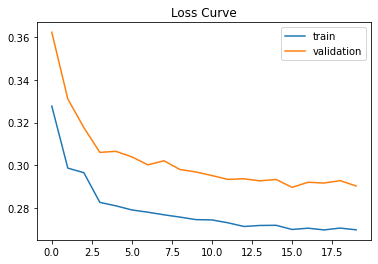

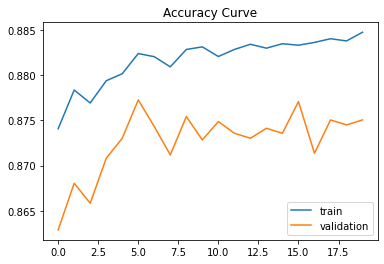

In [7]:
# plot loss curve
plt.plot(train_loss)
plt.plot(valid_loss)
plt.title("Loss Curve")
plt.legend(["train","validation"])
plt.show()

# plot accuracy curve
plt.plot(train_accuracy)
plt.plot(valid_accuracy)
plt.title("Accuracy Curve")
plt.legend(["train", "validation"])
plt.show()

绘制图像

In [9]:
# predict y
x_test = normalize(x_test)
y_test = predict(np.concatenate((np.ones((len(x_test),1)), x_test), 1),w)
rs = pd.DataFrame(y_test,columns=["label"]).astype(np.int)
rs.to_csv("ans2.csv")
rs

,label
0,0
1,0
2,0
3,0
4,0
...,...
27617,0
27618,0
27619,1
27620,0


最终预测，并且输出结果
## 结果与展望


相比于flawed版本：

* 进行了label标签的向量化
* 优化了regularization，并且常用的操作写成了函数
* 进行了cross validation
* 了解和掌握Mini-Batch Gradient Descent，flawed版本还是用的RMSE
* 更加深刻理解了`np.dot()`函数，在某些特殊情况下可以和`np.sum()`函数进行同义转换。
* 新了解了`np.clip()`函数
* 在深度学习中，MBGD要比BGD、SGD要更加常用一些。

一些问题：

* 有篇文章讲SGD $\approx$ MBGD？ https://zhuanlan.zhihu.com/p/72929546
* 需要深度了解一下MBDG，BDG，SDG的优点和缺点

### 关于正则化regularization

$L = \dfrac1n\sum(\hat y^n-(\sum w_ix_i + b))^2 + \lambda \sum(w_i)^2$

$\nabla w = \sum(\hat y^n-(\sum w_ix_i + b)) + 2 \lambda \sum(w_i) $

$\nabla b = \sum(\hat y^n-(\sum w_ix_i + b))$

loss 函数可以写成以下的样子：



## Others:

### Why SGD:

However, in other cases, evaluating the sum-gradient may require expensive evaluations of the gradients from all summand functions. When the data set is large and no simple formulas exist, evaluating the sums of gradients becomes very expensive, because evaluating the gradient requires evaluating all the summand functions' gradients. To economize on the computational cost at every iteration, stochastic gradient descent samples a subset of summand functions at every step.

<small> From https://en.wikipedia.org/wiki/Stochastic_gradient_descent </small>

### About MBGD
The mini-batch GD: it seeks to find a balance point between stochastic GD and batch GD.


### Pseudocode of gradient descent:

```
model = initialization(...)
n_epochs = ...
train_data = ...
for i in n_epochs:
	train_data = shuffle(train_data)
	X, y = split(train_data)
	predictions = predict(X, model)
	error = calculate_error(y, predictions)
model = update_model(model, error)
```